In [1]:
import jax
num_devices = jax.device_count()
device_type = jax.devices()[0].device_kind

print(f"Found {num_devices} JAX devices of type {device_type}.")
assert "TPU" in device_type, "Available device is not a TPU, please select TPU from Edit > Notebook settings > Hardware accelerator"

Found 8 JAX devices of type TPU v3.


In [2]:
import numpy as np
import jax
import jax.numpy as jnp

from pathlib import Path
from jax import pmap
from flax.jax_utils import replicate
from flax.training.common_utils import shard
from PIL import Image

from huggingface_hub import notebook_login
from diffusers import FlaxStableDiffusionPipeline

In [3]:
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

In [4]:
dtype = jnp.bfloat16

In [5]:
pipeline, params = FlaxStableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    revision="bf16",
    dtype=dtype,
)

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

tcmalloc: large alloc 1719074816 bytes == 0x86648000 @  0x7f1e8e96b680 0x7f1e8e98c824 0x5f8011 0x648191 0x5c38e6 0x4f2aee 0x64e458 0x504843 0x56a136 0x56822a 0x50a3b0 0x56b115 0x56822a 0x50a3b0 0x56b115 0x56822a 0x68c1e7 0x5ff1f4 0x5c3cb0 0x569f5e 0x5002e8 0x56b95e 0x5002e8 0x56b95e 0x5002e8 0x503f46 0x56a136 0x5f5e56 0x569f5e 0x5f5e56 0x56a136
Some of the weights of FlaxCLIPTextModel were initialized in bfloat16 precision from the model checkpoint at /home/artirj/.cache/huggingface/diffusers/models--CompVis--stable-diffusion-v1-4/snapshots/295cccdedbd5f87458186972858dc85c7e70c10a/text_encoder:
[('text_model', 'embeddings', 'position_embedding', 'embedding'), ('text_model', 'embeddings', 'token_embedding', 'embedding'), ('text_model', 'encoder', 'layers', '0', 'layer_norm1', 'bias'), ('text_model', 'encoder', 'layers', '0', 'layer_norm1', 'scale'), ('text_model', 'encoder', 'layers', '0', 'layer_norm2', 'bias'), ('text_model', 'encoder', 'layers', '0', 'layer_norm2', 'scale'), ('text_m

Some of the weights of FlaxStableDiffusionSafetyChecker were initialized in bfloat16 precision from the model checkpoint at /home/artirj/.cache/huggingface/diffusers/models--CompVis--stable-diffusion-v1-4/snapshots/295cccdedbd5f87458186972858dc85c7e70c10a/safety_checker:
[('concept_embeds',), ('concept_embeds_weights',), ('special_care_embeds',), ('special_care_embeds_weights',), ('vision_model', 'vision_model', 'embeddings', 'class_embedding'), ('vision_model', 'vision_model', 'embeddings', 'patch_embedding', 'kernel'), ('vision_model', 'vision_model', 'embeddings', 'position_embedding', 'embedding'), ('vision_model', 'vision_model', 'encoder', 'layers', '0', 'layer_norm1', 'bias'), ('vision_model', 'vision_model', 'encoder', 'layers', '0', 'layer_norm1', 'scale'), ('vision_model', 'vision_model', 'encoder', 'layers', '0', 'layer_norm2', 'bias'), ('vision_model', 'vision_model', 'encoder', 'layers', '0', 'layer_norm2', 'scale'), ('vision_model', 'vision_model', 'encoder', 'layers', '0

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


In [6]:
prompt = "A blue cube in front of a red cube"
prompt = [prompt] * jax.device_count()
prompt_ids = pipeline.prepare_inputs(prompt)
prompt_ids.shape

(8, 77)

In [7]:
p_params = replicate(params)

In [8]:
prompt_ids = shard(prompt_ids)
prompt_ids.shape

(8, 1, 77)

In [9]:
def create_key(seed=0):
    return jax.random.PRNGKey(seed)

In [10]:
rng = create_key(0)
rng = jax.random.split(rng, jax.device_count())

In [15]:
pipeline??

In [11]:
images = pipeline(prompt_ids, p_params, rng, jit=True)[0]

In [12]:
images = images.reshape((images.shape[0],) + images.shape[-3:])
images = pipeline.numpy_to_pil(images)

In [13]:
def image_grid(imgs, rows, cols):
    w,h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

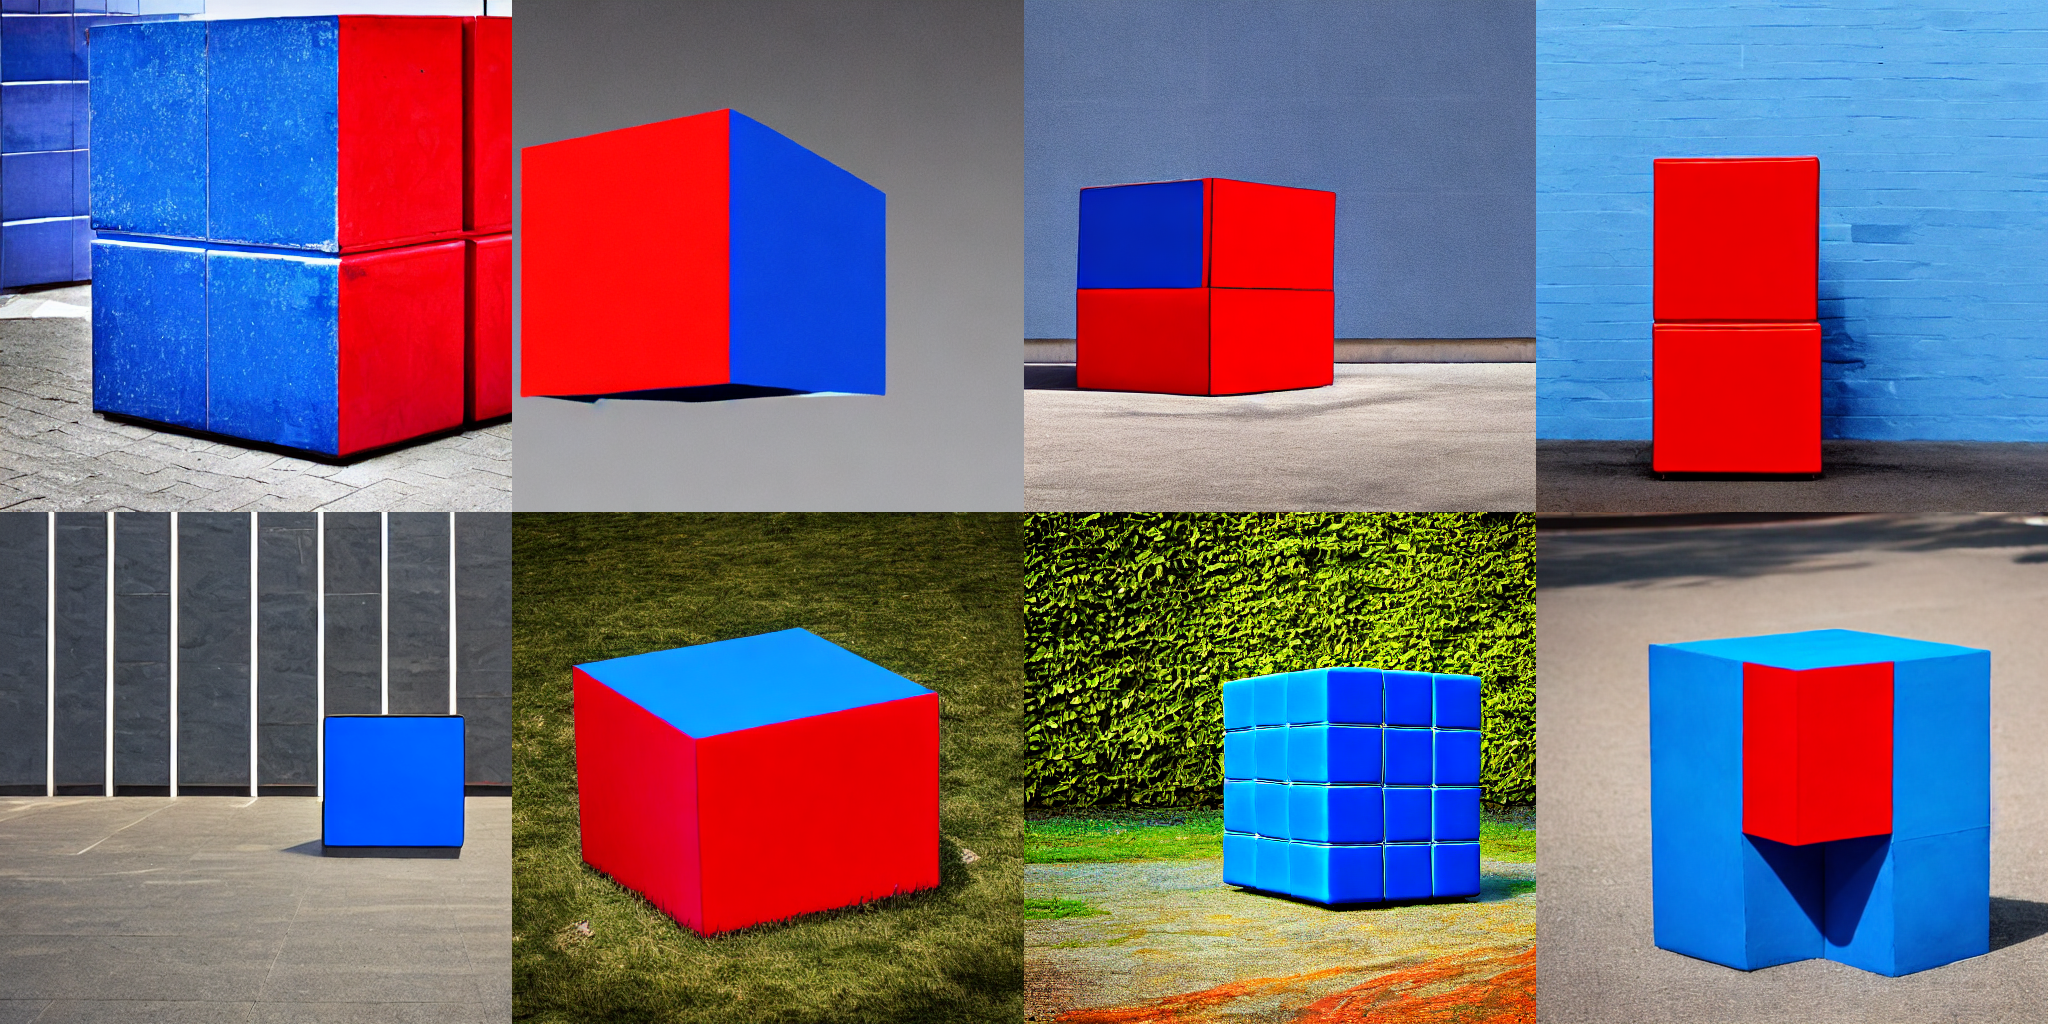

In [14]:
image_grid(images, 2, 4)



In [ ]:
images